In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
from keras import metrics
from keras.callbacks import ModelCheckpoint

from data_in_2s import data_in, normali
from test_data_in_2s import test_data_in
from orignal_model import ori_model
from judge_model import judge_model
from modify_model import modify_model

Using TensorFlow backend.


In [2]:
num_test = 1
X_train, y_train = data_in(num_test)

In [3]:
#Nomalization
y_train = (y_train-50)/150
X_train = normali(X_train)
print('Shape of X_train is: ' + str(X_train.shape))
print('Shape of y_train is: ' + str(y_train.shape))

Shape of X_train is: (6099, 1000, 5)
Shape of y_train is: (6099, 1)


In [4]:
#Import and Split test data
X_test, y_test = test_data_in(num_test)

y_test = (y_test-50)/150
X_test = normali(X_test)

print('The shape of X_test is: ' + str(X_test.shape))
print('The shape of y_test is: ' + str(y_test.shape))

The shape of X_test is: (295, 1000, 5)
The shape of y_test is: (295, 1)


## Original Model

In [5]:
original_model = ori_model((1000, 5), 8, pool_size=2)

/media/zhuolun/DATA/Project/Atheros-CSI-Tool-UserSpace-APP/recvCSI/Xiaoshi/Xiong/Troika mod/Troika mod/orignal_model.py:199: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  model = Model(input=inputs, output=output)


In [6]:
optm = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=3*10**(-4))
original_model.compile(loss= "mse", 
              optimizer=optm, 
              metrics=["mse"])

In [7]:
filepath="Troika_judge_person%.2d.hdf5"%num_test
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_mean_squared_error', 
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks_list = [checkpoint]
history = original_model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=128, 
                    validation_split=0.2, 
                    callbacks=callbacks_list,
                    shuffle=True,
                    verbose=1)

Train on 4879 samples, validate on 1220 samples
Epoch 1/100
4879/4879 [==============================] - 10s 2ms/step - loss: 0.4968 - mean_squared_error: 0.0256 - val_loss: 0.4773 - val_mean_squared_error: 0.0233

Epoch 00001: val_mean_squared_error improved from inf to 0.02333, saving model to Troika_judge_person01.hdf5
Epoch 2/100
4879/4879 [==============================] - 4s 756us/step - loss: 0.4519 - mean_squared_error: 0.0175 - val_loss: 0.4424 - val_mean_squared_error: 0.0324

Epoch 00002: val_mean_squared_error did not improve from 0.02333
Epoch 3/100
4879/4879 [==============================] - 4s 758us/step - loss: 0.3958 - mean_squared_error: 0.0106 - val_loss: 0.4299 - val_mean_squared_error: 0.0727

Epoch 00003: val_mean_squared_error did not improve from 0.02333
Epoch 4/100
4879/4879 [==============================] - 4s 762us/step - loss: 0.3394 - mean_squared_error: 0.0076 - val_loss: 0.3970 - val_mean_squared_error: 0.0930

Epoch 00004: val_mean_squared_error did no

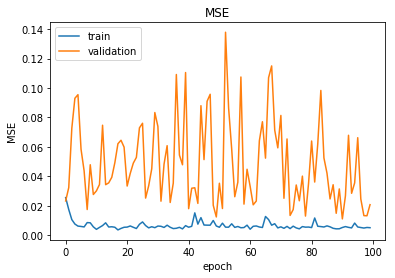

In [8]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

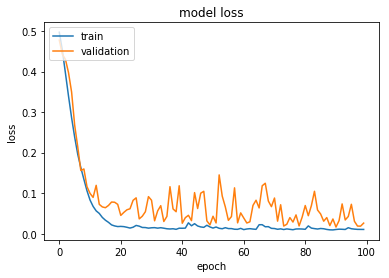

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
filepath="Troika_judge_person%.2d.hdf5"%num_test
original_model.load_weights(filepath)

In [11]:
predict = original_model.predict(X_test)

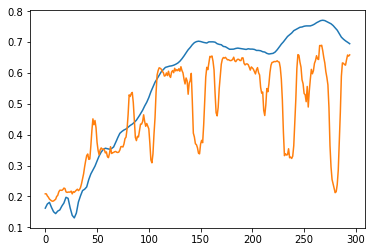

In [12]:
plt.plot(y_test)
plt.plot(predict)

In [13]:
y_error = abs(predict - y_test)*150
print('The avarage predict error: ', np.mean(y_error))

The avarage predict error:  16.385928652


## Judge Model

In [18]:
#-----------------------------
threshold = 0.03  #Admit error
#-----------------------------

y_train_pre = original_model.predict(X_train)
diff = abs(y_train_pre - y_train)
diff[diff<threshold] = 0
diff[diff>=threshold] = 1

print('Number of correct data: ', diff[diff==0].shape[0])
print('Number of incorrect data: ', diff[diff==1].shape[0])

Number of correct data:  3068
Number of incorrect data:  3031


In [19]:
jud_model = judge_model((1000, 5), 8, pool_size=2)

/media/zhuolun/DATA/Project/Atheros-CSI-Tool-UserSpace-APP/recvCSI/Xiaoshi/Xiong/Troika mod/Troika mod/judge_model.py:199: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  model = Model(input=inputs, output=output)


In [20]:
optm = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=3*10**(-4))
jud_model.compile(loss= "mse", 
              optimizer=optm, 
              metrics=["mse"])

In [21]:
filepath="Troika_judge_judge_person%.2d.hdf5"%num_test
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_mean_squared_error', 
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks_list = [checkpoint]
history = jud_model.fit(X_train, diff,
                    epochs=100, 
                    batch_size=128, 
                    validation_split=0.3, 
                    callbacks=callbacks_list,
                    shuffle=True,
                    verbose=1)

Train on 4269 samples, validate on 1830 samples
Epoch 1/100
4269/4269 [==============================] - 9s 2ms/step - loss: 0.7205 - mean_squared_error: 0.2457 - val_loss: 0.7594 - val_mean_squared_error: 0.2974

Epoch 00001: val_mean_squared_error improved from inf to 0.29738, saving model to Troika_judge_judge_person01.hdf5
Epoch 2/100
4269/4269 [==============================] - 3s 784us/step - loss: 0.6858 - mean_squared_error: 0.2409 - val_loss: 0.7305 - val_mean_squared_error: 0.3067

Epoch 00002: val_mean_squared_error did not improve from 0.29738
Epoch 3/100
4269/4269 [==============================] - 3s 784us/step - loss: 0.6417 - mean_squared_error: 0.2392 - val_loss: 0.6374 - val_mean_squared_error: 0.2590

Epoch 00003: val_mean_squared_error improved from 0.29738 to 0.25900, saving model to Troika_judge_judge_person01.hdf5
Epoch 4/100
4269/4269 [==============================] - 3s 785us/step - loss: 0.5923 - mean_squared_error: 0.2362 - val_loss: 0.5860 - val_mean_square

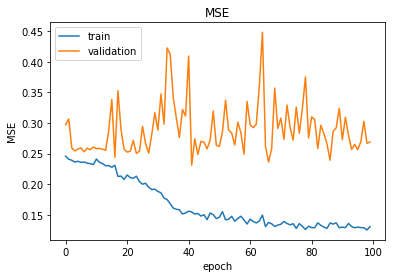

In [22]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

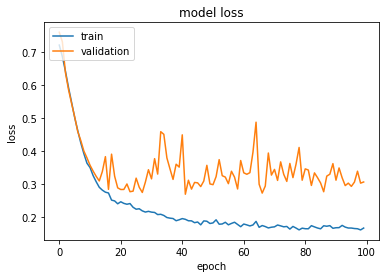

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [24]:
filepath="Troika_judge_judge_person%.2d.hdf5"%num_test
jud_model.load_weights(filepath)

In [25]:
#evaluate
# y_test_pre = jud_model.predict(X_test)
# y_test_diff = abs(y_test_pre - y_test)
# y_test_diff[y_test_diff<threshold] = 0
# y_test_diff[y_test_diff>=threshold] = 1
# eva = jud_model.evaluate(X_test, y_test_diff, batch_size=32, verbose=1, sample_weight=None)
# print()
# print("Loss = " + str(eva[0]))
# print("Test Accuracy = " + str(eva[1]))

## Modify and Final Result

In [26]:
X_train_mod = X_train[np.where(diff>=threshold)[0], :, :] 
y_train_mod = y_train[diff>=threshold]

In [27]:
mod_model = modify_model((1000, 5), 8, pool_size=2)

/media/zhuolun/DATA/Project/Atheros-CSI-Tool-UserSpace-APP/recvCSI/Xiaoshi/Xiong/Troika mod/Troika mod/modify_model.py:198: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  model = Model(input=inputs, output=output)


In [28]:
optm = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=3*10**(-4))
mod_model.compile(loss= "mse", 
              optimizer=optm, 
              metrics=["mse"])

In [29]:
filepath="Troika_judge_mod_person%.2d.hdf5"%num_test
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_mean_squared_error', 
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks_list = [checkpoint]
history = mod_model.fit(X_train_mod, y_train_mod, 
                    epochs=100, 
                    batch_size=128, 
                    validation_split=0.2, 
                    callbacks=callbacks_list,
                    shuffle=True,
                    verbose=1)

Train on 2424 samples, validate on 607 samples
Epoch 1/100
2424/2424 [==============================] - 8s 3ms/step - loss: 0.6427 - mean_squared_error: 0.1509 - val_loss: 0.5883 - val_mean_squared_error: 0.0882

Epoch 00001: val_mean_squared_error improved from inf to 0.08818, saving model to Troika_judge_mod_person01.hdf5
Epoch 2/100
2424/2424 [==============================] - 2s 742us/step - loss: 0.5610 - mean_squared_error: 0.0630 - val_loss: 0.5508 - val_mean_squared_error: 0.0585

Epoch 00002: val_mean_squared_error improved from 0.08818 to 0.05849, saving model to Troika_judge_mod_person01.hdf5
Epoch 3/100
2424/2424 [==============================] - 2s 737us/step - loss: 0.5451 - mean_squared_error: 0.0613 - val_loss: 0.5192 - val_mean_squared_error: 0.0460

Epoch 00003: val_mean_squared_error improved from 0.05849 to 0.04604, saving model to Troika_judge_mod_person01.hdf5
Epoch 4/100
2424/2424 [==============================] - 2s 737us/step - loss: 0.5236 - mean_squared_err

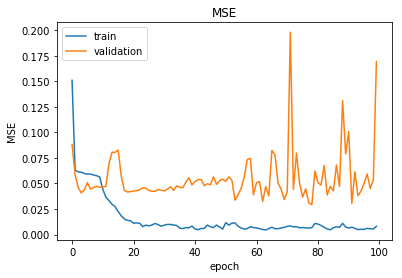

In [30]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

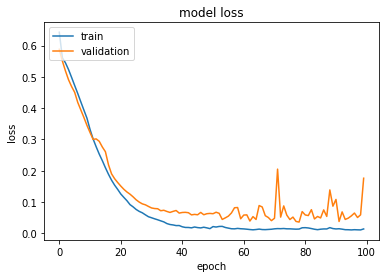

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [32]:
filepath="Troika_judge_mod_person%.2d.hdf5"%num_test
mod_model.load_weights(filepath)

In [45]:
predict       = original_model.predict(X_test)
predict_judge = jud_model.predict(X_test)
predict_judge[predict_judge<0.7] = 0
predict_judge[predict_judge>=0.7] = 1
predict_mod   = mod_model.predict(X_test)

predict_mod   = predict_judge * predict_mod
predict_res   = (1 - predict_judge) * predict
predict_fin   = predict_res + predict_mod

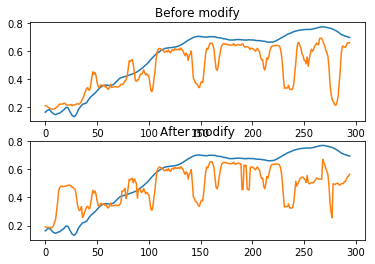

In [46]:
plt.subplot(211)
plt.plot(y_test)
plt.plot(predict)
plt.title('Before modify')
plt.subplot(212)
plt.plot(y_test)
plt.plot(predict_fin)
plt.title('After modify')
plt.show()

In [47]:
y_error1 = abs(y_test - predict) * 150
y_error2 = abs(y_test - predict_fin) * 150
print('The avarage predict error before modify: ', np.mean(y_error1))
print('The avarage predict error after modify: ', np.mean(y_error2))

The avarage predict error before modify:  16.385928652
The avarage predict error after modify:  20.2720506152
